In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import sys
import matplotlib.pyplot as plt
from dateutil.parser import parse
import parse as str_parse
from intersection_proximity import intersection_proximity
from importlib import reload
from scipy.spatial import distance
reload(intersection_proximity)
from sklearn import preprocessing
import seaborn as sns

users = pd.read_csv('ml-users.csv') 
%matplotlib notebook

In [128]:
crop_rows = -1

In [132]:
df_interactions = pd.read_csv('ml-interactions.tar.gz', compression='gzip')

if crop_rows > 0:
    df_interactions = df_interactions.head(crop_rows)

isna_result = pd.isna(df_interactions['action'])
df_interactions= df_interactions[~isna_result]
isna_result = pd.isna(df_interactions['action'])
assert sum(df_interactions['action'].isna()) == 0

df_interactions.rename(columns = {'ml-interactions.csv':'timestamp'}, inplace = True)

In [133]:
%%time
df_interactions['timestamp'] = df_interactions['timestamp'].apply(lambda x: parse(x))

CPU times: user 28min 57s, sys: 25.5 s, total: 29min 23s
Wall time: 31min 33s


In [134]:
%%time
df_interactions.sort_values(by=['user_id', 'timestamp'], inplace=True)

CPU times: user 1min 40s, sys: 11.1 s, total: 1min 51s
Wall time: 2min 1s


In [150]:
# df_interactions.head(15000).to_csv('h.csv')

In [135]:
# df_interactions.to_pickle(f'df_interactions_all.pickle')

In [139]:
df_interactions = pd.read_pickle(f'df_interactions_all.pickle')

In [151]:
# Fill all temporary label ID's before a FinishLabeling event. (see docs for fillna)
# TODO: Should we analyze the last 5/10 seconds before a label is placed? 


# fill nan temporary label id's
df_interactions['temporary_label_id'] = df_interactions['temporary_label_id'].fillna(method='bfill')

# get rid of nan label id's
df_interactions = df_interactions[~pd.isna(df_interactions['temporary_label_id'])]

In [152]:
label_correctness = pd.read_csv('ml-label-correctness.csv')

In [153]:
labeling_cols = ['user_id', 'audit_task_id', 'temporary_label_id']

In [154]:
label_correctness.set_index(labeling_cols, inplace=True)

In [155]:
# TODO: figure out why there are duplicates
label_correctness = label_correctness[~label_correctness.index.duplicated()]

In [156]:
interaction_groups = df_interactions.groupby(labeling_cols)

## Calculate features

In [158]:
label_features = interaction_groups.apply(lambda x: x['zoom'].mean()).to_frame(name='zoom')

In [159]:
# filter rows
label_features = label_features[interaction_groups \
                                .apply(lambda x: sum(x['action'] == 'LabelingCanvas_FinishLabeling') == 1)]

In [160]:
def label_type(x):
    try:
        note = x['note'][x['action'] == 'LabelingCanvas_FinishLabeling'].iloc[0]
        return str_parse.parse('labelType:{},canvasX:{},canvasY:{}', note)[0]
    except (IndexError, KeyError) as e:
        return ''

label_features['label_type'] = interaction_groups.apply(label_type)

In [201]:
label_features['mousemoves'] = interaction_groups.apply(lambda x: sum(x['action'] == 'LowLevelEvent_mousemove'))

In [202]:
def normalize_headings(heading_list):
    start_heading = heading_list.iloc[0]
    h = heading_list - start_heading
    h[h > 180] = h[h > 180] - 360
    return h

def range_headings(heading_list):
    norm = normalize_headings(heading_list)
    return np.max(norm) - np.min(norm)
#     return pd.Series({'heading_min': np.min(norm), 'heading_max': np.max(norm), 'heading_range': np.max(norm) - np.min(norm)})

In [203]:
label_features['heading_range'] = interaction_groups.apply(lambda x: x.groupby('gsv_panorama_id').apply(lambda y: range_headings(y['heading'])).mean())

In [204]:
def total_time(x):
    time = x['timestamp'].sort_values()
    return (time.iloc[-1] - time.iloc[0]).total_seconds()

# Time from start to finish
label_features['total_time'] = interaction_groups.apply(lambda x: total_time(x))

In [205]:
def time_between_pov_change_and_label(x):
    pov_change = x['timestamp'][x['action'] == 'POV_Changed'].max()
    last_time = x['timestamp'].max()
    return (last_time - pov_change).total_seconds()
                                
clicks_per_pano = df_interactions.groupby('user_id').apply(lambda x: sum(x['action'] == 'LowLevelEvent_click') / x['gsv_panorama_id'].unique().size)


In [206]:
label_features['pov_changes_per_pano'] = interaction_groups.apply(lambda x: sum(x['action'] == 'POV_Changed') / x['gsv_panorama_id'].nunique() \
                                                                  if x['gsv_panorama_id'].nunique() > 0 else 0)

In [207]:
def time_per_pano(x):
    try:
        time = x['timestamp'].sort_values()
        return ((time.iloc[-1] - time.iloc[0]).total_seconds() / x['gsv_panorama_id'].nunique())
    except ZeroDivisionError as e:
        return 0

label_features['time_per_pano'] = interaction_groups.apply(time_per_pano)

In [208]:
def mouseups(x):
    try:
        return sum(x['action'] == 'LowLevelEvent_mouseup') / x['gsv_panorama_id'].nunique()
    except ZeroDivisionError as e:
        return 0

label_features['mouseups_per_pano'] = interaction_groups.apply(mouseups) 

In [209]:
def intersection_proximity_percentage(x):
    try:
        evt = x[x['action'] == 'LabelingCanvas_FinishLabeling'].iloc[0]
        try:
            distance, percentage = intersection_proximity.compute_proximity(evt.lat, evt.lng)
            return percentage
        except Exception as e:
#             print(evt.lat, evt.lng)
            # Throws error when the distance is 0 or street length. TODO: fix.
            return 0
    except IndexError as e:
        # TODO: determine why some events have no finishlabeling event
        return -1

In [210]:
label_features['intersection_proximity'] = interaction_groups.apply(intersection_proximity_percentage)

In [211]:
def up_keys_per_pano(x):
    try:
        return (sum(x['note'] == 'keyCode:38') / x['gsv_panorama_id'].nunique())
    except ZeroDivisionError as e:
        return 0

label_features['up_keys_per_pano'] = interaction_groups.apply(up_keys_per_pano)

In [212]:
def canvas_coord(x, index):
    try:
        note = x['note'][x['action'] == 'LabelingCanvas_FinishLabeling'].iloc[0]
        return str_parse.parse('labelType:{},canvasX:{},canvasY:{}', note)[index]
    except Exception as e:
        return ''

label_features['canvas_x'] = interaction_groups.apply(lambda x: canvas_coord(x, 1))
label_features['canvas_y'] = interaction_groups.apply(lambda x: canvas_coord(x, 2))

In [26]:
# TODO: speed up
# def mouse_movement_speed(x):
#     relevant_actions = x[x['action'] == 'LowLevelEvent_mousemove']
#     relevant_actions.sort_values('timestamp')
#     last_row = None
#     total_dist = 0
#     total_time = 0
#     last_result = None
#     for index, row in relevant_actions.iterrows():
#         result = str_parse.parse('cursorX:{},cursorY:{}', row['note'])
#         if last_row is not None and ((row['timestamp'] - last_row['timestamp']).total_seconds() < 0.4):
#             total_time += (row['timestamp'] - last_row['timestamp']).total_seconds()
#             total_dist += distance.euclidean([int(result[0]), int(result[1])], [int(last_result[0]), int(last_result[1])])

#         last_result = result
#         last_row = row
        
#     try:
#         return total_dist / total_time
#     except ZeroDivisionError:
#         return 0
    
# label_features['mouse_speed'] = interaction_groups.apply(mouse_movement_speed)

In [218]:
def mouse_movement_speed(x, count=0):
    relevant_actions = x[x['action'] == 'LowLevelEvent_mousemove']
    relevant_actions.sort_values('timestamp')
    last_row = None
    total_dist = 0
    last_result = None
    for index, row in relevant_actions.iterrows():
        result = str_parse.parse('cursorX:{},cursorY:{}', row['note'])
        if last_row is not None and ((row['timestamp'] - last_row['timestamp']).total_seconds() < 0.4):
            total_dist += distance.euclidean([int(result[0]), int(result[1])], [int(last_result[0]), int(last_result[1])])

        last_result = result
        last_row = row
        
    try:
        return total_dist / (np.max((relevant_actions['timestamp'].values) - np.min(relevant_actions['timestamp'].values)).total_seconds())
    except Exception:
        return 0
    
label_features['mouse_speed'] = interaction_groups.apply(mouse_movement_speed)

In [219]:
label_features[~np.isfinite(label_features['mouse_speed'])]['mouse_speed'] = 0
label_features['mouse_speed'] = np.abs(label_features['mouse_speed'])

In [166]:
le = preprocessing.LabelEncoder()
le.fit(np.unique(df_interactions['action']))

label_features['sequence'] = interaction_groups.apply(lambda x: le.transform(x.action)[:500])

In [167]:
# max_seq_len = label_features['sequence'].apply(lambda x: len(x)).max()
max_seq_len=500

In [175]:
label_features['correct'] = label_correctness['correct'].apply(lambda x: True if x == 't' else False if x == 'f' else np.nan)

In [220]:
validated_label_features = label_features[~pd.isna(label_features['correct'])]

In [318]:
validated_label_features.reset_index(inplace=True)

In [320]:
validated_label_features

,user_id,audit_task_id,temporary_label_id,zoom,label_type,mousemoves,intersection_proximity,sequence,correct,heading_range,total_time,pov_changes_per_pano,time_per_pano,mouseups_per_pano,up_keys_per_pano,canvas_x,canvas_y,mouse_speed,label_id
0,0e1ae564-6d72-4670-98e4-71369cc5ab26,3366.0,5.0,1.000000,NoCurbRamp,629,7.440208,"[55, 80, 53, 62, 63, 61, 61, 61, 61, 61, 62, 6...",True,48.3,30.911,46.000000,6.182200,4.800000,0.000000,642,226,227.300825,1
1,0e1ae564-6d72-4670-98e4-71369cc5ab26,3367.0,7.0,1.000000,NoCurbRamp,355,11.063844,"[96, 100, 96, 87, 63, 61, 61, 87, 61, 61, 61, ...",False,34.7812,12.329,18.000000,6.164500,4.500000,0.000000,490,294,273.813002,1
2,0e1ae564-6d72-4670-98e4-71369cc5ab26,3368.0,3.0,1.000000,SurfaceProblem,679,36.127420,"[55, 80, 53, 62, 63, 61, 61, 62, 63, 61, 61, 6...",True,41.5312,27.648,25.000000,6.912000,4.250000,0.000000,484,167,277.971782,3
3,0e1ae564-6d72-4670-98e4-71369cc5ab26,3368.0,4.0,1.000000,SurfaceProblem,177,53.574222,"[55, 62, 63, 61, 61, 61, 61, 61, 61, 61, 61, 6...",False,17.5312,6.424,14.000000,3.212000,3.500000,0.000000,490,147,284.149049,3
4,0e1ae564-6d72-4670-98e4-71369cc5ab26,3378.0,20.0,1.000000,CurbRamp,253,7.672290,"[55, 53, 80, 62, 63, 61, 61, 61, 61, 61, 61, 6...",True,178.969,9.315,17.000000,4.657500,3.500000,1.000000,426,206,327.806943,0
5,0e1ae564-6d72-4670-98e4-71369cc5ab26,3639.0,3.0,1.000000,SurfaceProblem,98,98.591111,"[63, 62, 61, 63, 62, 61, 62, 63, 61, 61, 61, 6...",False,0,3.756,0.000000,3.756000,3.000000,0.000000,555,308,328.150458,3
6,0e1ae564-6d72-4670-98e4-71369cc5ab26,3641.0,5.0,1.000000,SurfaceProblem,163,71.182261,"[63, 62, 61, 61, 61, 61, 61, 61, 61, 61, 62, 6...",False,0,5.662,0.000000,5.662000,4.000000,0.000000,510,305,374.724318,3
7,0e1ae564-6d72-4670-98e4-71369cc5ab26,3641.0,6.0,1.000000,SurfaceProblem,260,40.862629,"[62, 63, 61, 58, 61, 87, 61, 87, 61, 87, 61, 8...",False,0,11.045,10.500000,5.522500,2.500000,1.000000,90,349,172.182525,3
8,0e1ae564-6d72-4670-98e4-71369cc5ab26,3641.0,8.0,1.000000,SurfaceProblem,353,13.255642,"[63, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 6...",True,51.1875,9.982,47.500000,4.991000,3.000000,1.000000,398,235,267.149748,3
9,0e1ae564-6d72-4670-98e4-71369cc5ab26,3641.0,9.0,1.000000,SurfaceProblem,190,13.255642,"[62, 96, 63, 61, 61, 61, 61, 61, 61, 61, 61, 6...",False,353.438,5.596,40.000000,5.596000,6.000000,0.000000,267,172,632.198946,3


In [332]:
turkers = users[users[' role'] == 'Turker']['user_id']

In [343]:
# Differentiate Turker vs. Registered
validated_label_features['is_turker'] = validated_label_features.apply(lambda x: x['user_id'] in turkers.values, axis=1)

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [346]:
validated_label_features.set_index(labeling_cols, inplace=True)

## Make plots

In [391]:
def plot_intersection_proximity(df, title):
    plt.figure()
    plt.title(title)
    plt.xlabel('intersection proxi mity (%)')
    plt.ylabel('relative count')
    plt.hist(df[df['correct'] == True]['intersection_proximity'], density=True, alpha=0.2, bins=20, label='correct')
    plt.hist(df[df['correct'] == False]['intersection_proximity'], density=True, alpha=0.2, bins=20, label='incorrect')
    plt.legend()

<IPython.core.display.Javascript object>


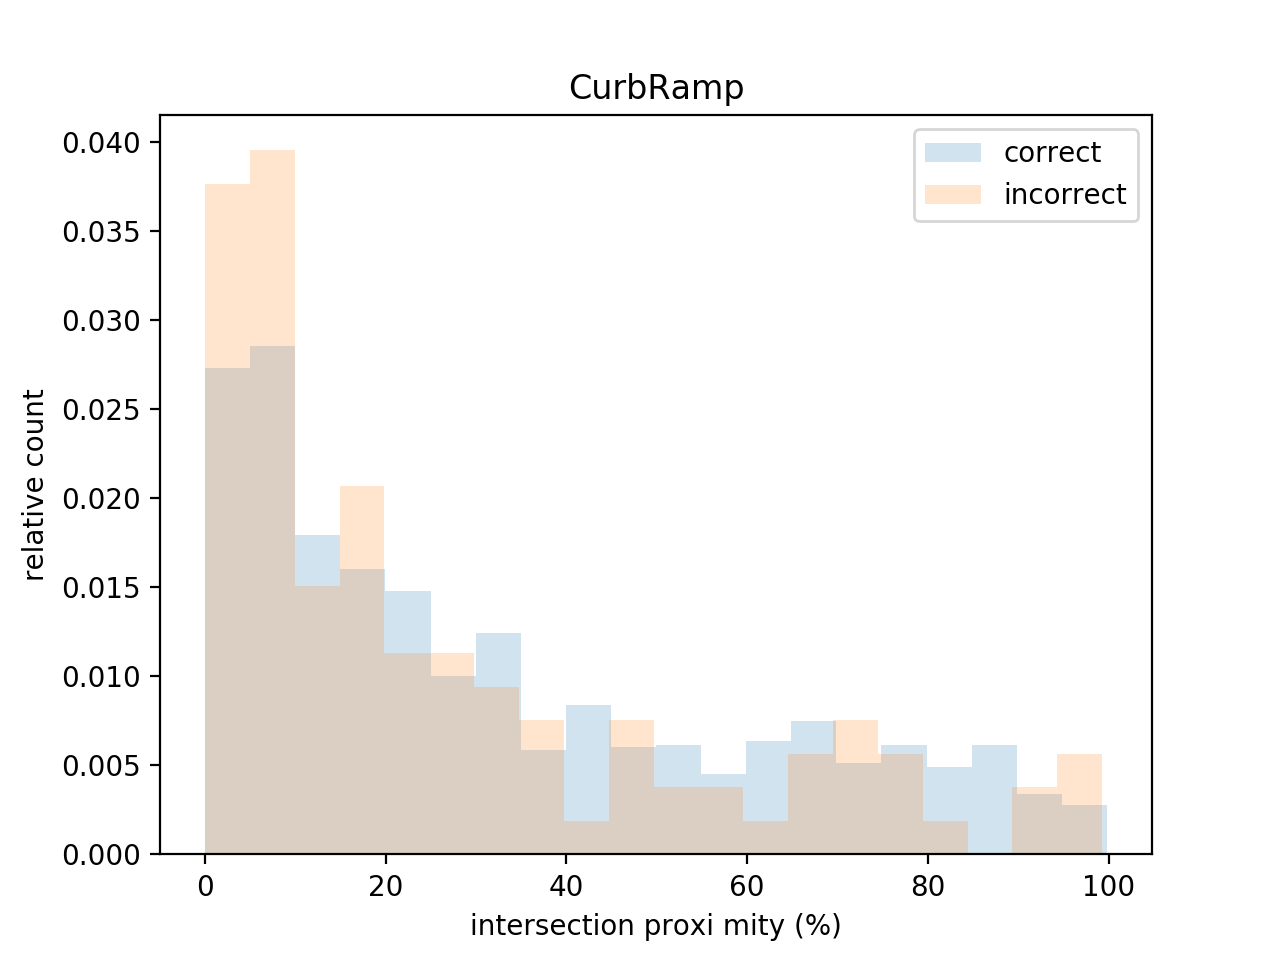

<IPython.core.display.Javascript object>


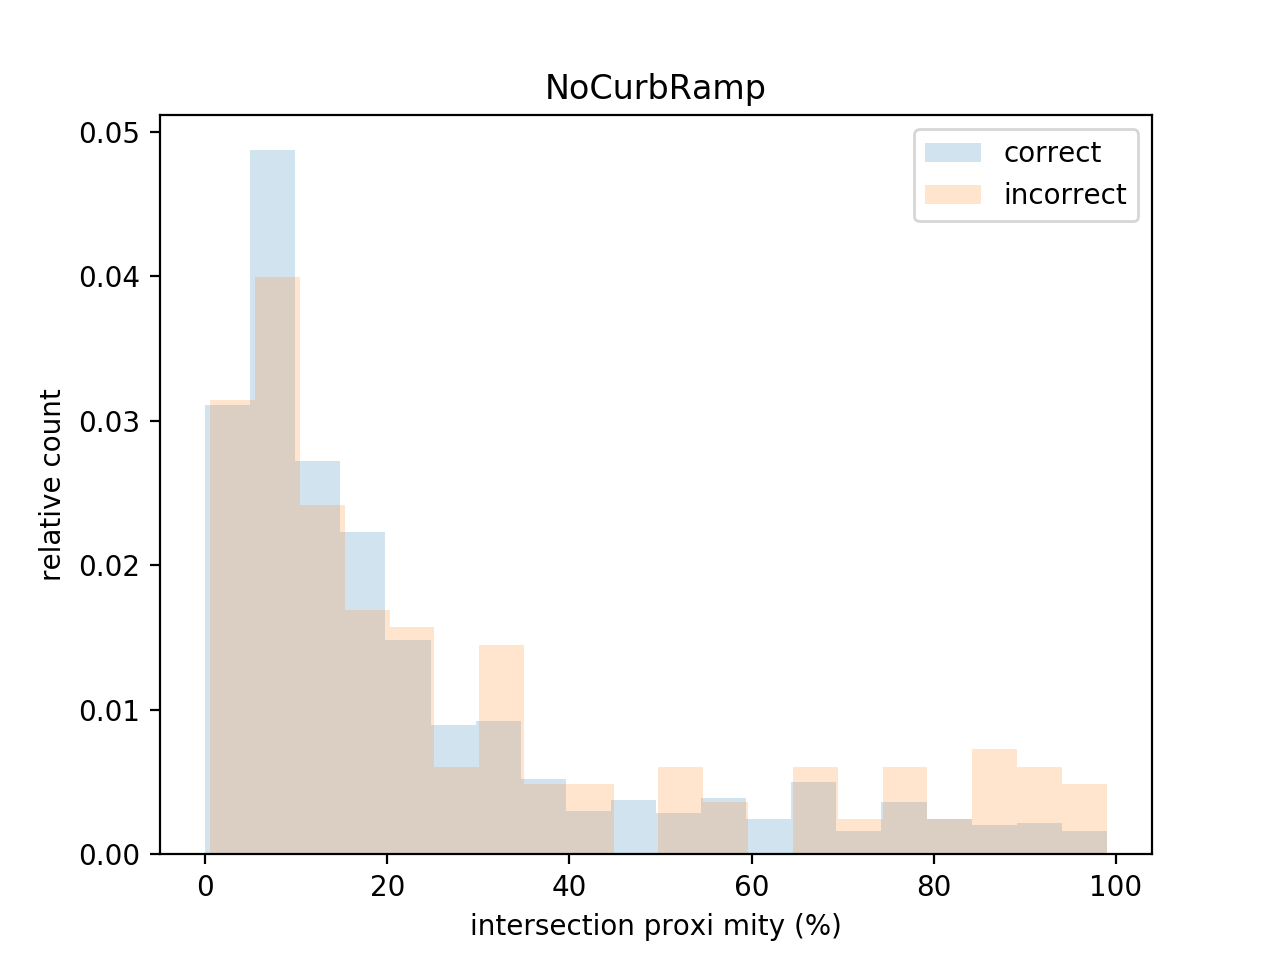

<IPython.core.display.Javascript object>


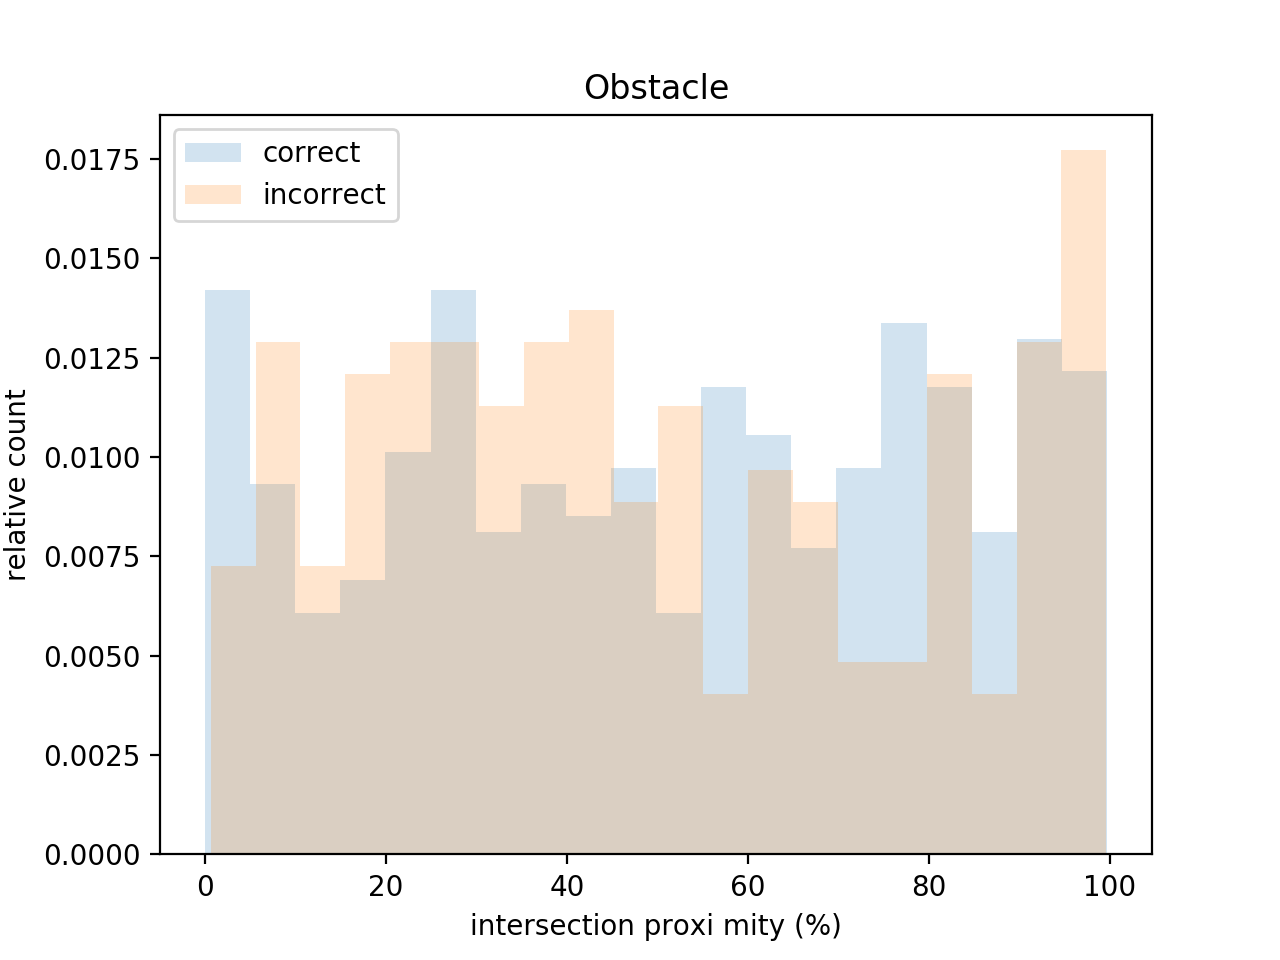

<IPython.core.display.Javascript object>


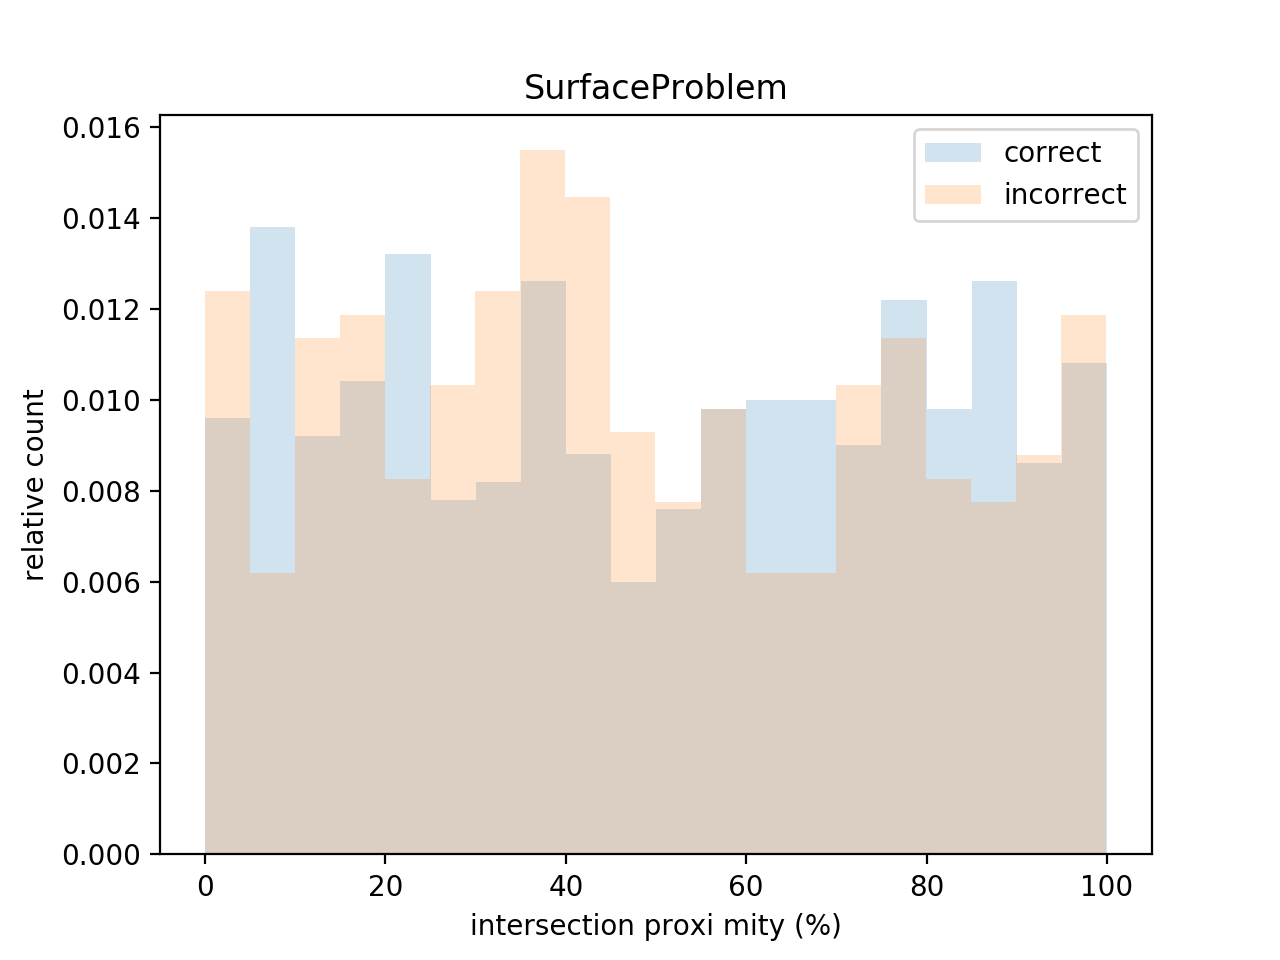

""


In [392]:
validated_label_features.groupby('label_type').apply(lambda x: plot_intersection_proximity(x, x.name))


In [ ]:
plot_intersection_proximity(validated_label_features, 'Aggregate')

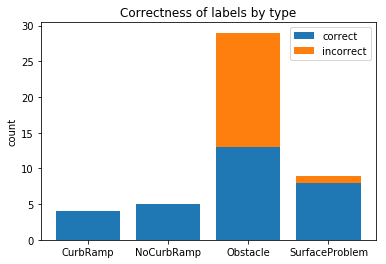

In [34]:
plt.figure()
correct_labels = validated_label_features['label_type'][validated_label_features['correct'] == True].value_counts()
incorrect_labels = validated_label_features['label_type'][validated_label_features['correct'] == False].value_counts()
df = pd.concat([correct_labels.rename('correct'), incorrect_labels.rename('incorrect')], axis=1, sort=True)
plt.bar(df.index, df['correct'], label='correct')
plt.bar(df.index, df['incorrect'], bottom=df['correct'], label='incorrect')
plt.ylabel('count')
plt.title('Correctness of labels by type')
plt.legend()

## Correlation Matrix

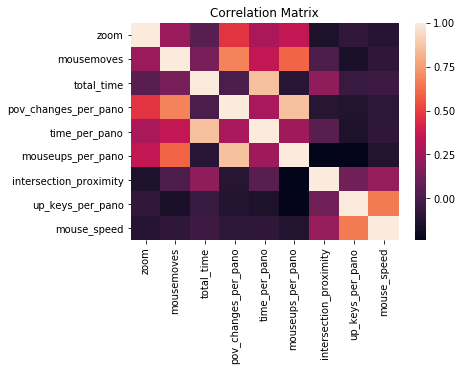

In [271]:
plt.figure()
plt.title('Correlation Matrix')
sns.heatmap(validated_label_features.corr())

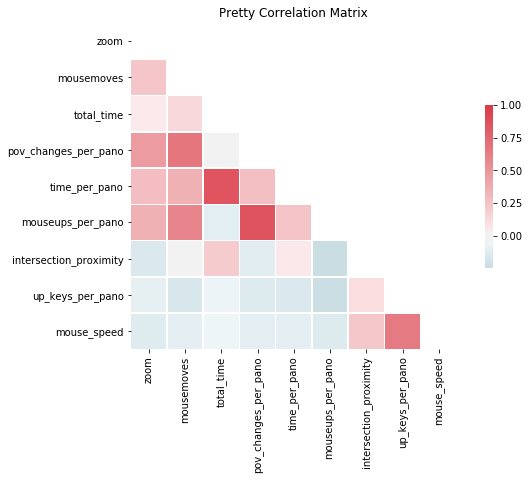

In [272]:
# Compute the correlation matrix
corr = validated_label_features.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from (mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Pretty Correlation Matrix')
# Generate a custom diverging colormap
cmap = sns.diverging_palette (220, 10, as_cmap=True)
# Draw heatmap w/the mask & correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5,cbar_kws={"shrink":.5})

# ML Pipeline

In [2]:
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

In [3]:
le = preprocessing.LabelEncoder()
# transform label_type into an int
validated_label_features['label_id'] = le.fit_transform(validated_label_features['label_type'])

NameError: name 'validated_label_features' is not defined

In [397]:
features = ['zoom', 'label_id', 'mousemoves', 'heading_range', 
            'total_time', 'pov_changes_per_pano', 'intersection_proximity',
           'time_per_pano', 'mouseups_per_pano', 'up_keys_per_pano', 'canvas_x', 'canvas_y', 'mouse_speed']

In [398]:
X = validated_label_features[features].values
y = validated_label_features['correct'].values
y = validated_label_features['is_turker'].values

In [399]:
# Undersample the majority class
incorrect_indices, = np.where(y == 0)
correct_indices, = np.where(y == 1)
needed = min(len(incorrect_indices), len(correct_indices))
chosen_indices = np.concatenate((np.random.choice(correct_indices, needed, replace=False), np.random.choice(incorrect_indices, needed, replace=False)))

X = X[chosen_indices]
y = y[chosen_indices]

In [400]:
y = y.astype(int)

<IPython.core.display.Javascript object>


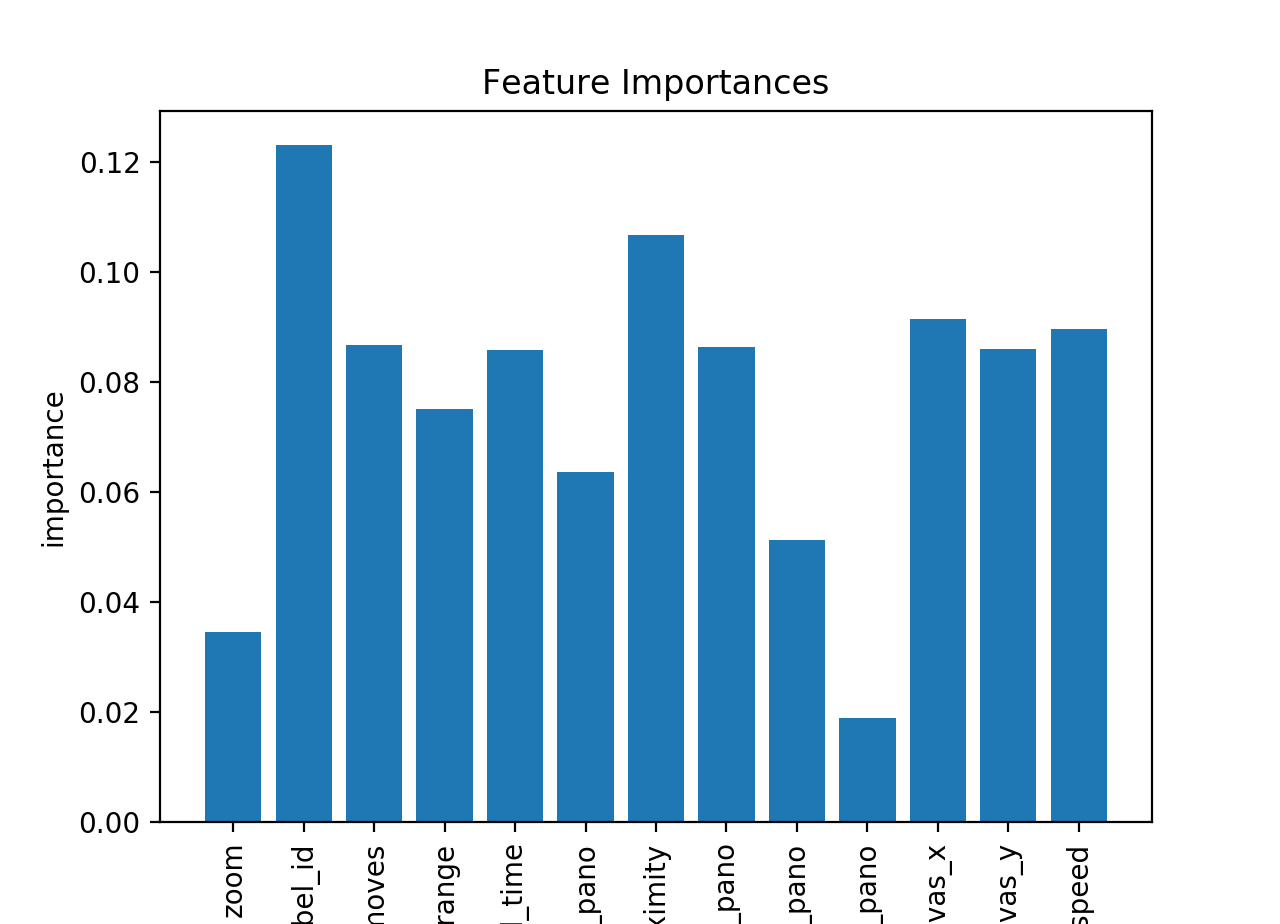

Text(0, 0.5, 'importance')

In [401]:
plt.figure()
plt.title('Feature Importances')
r = RandomForestClassifier(n_estimators=100)
r.fit(X, y)
plt.bar(features, r.feature_importances_)
plt.xticks(rotation=90)
plt.ylabel('importance')

In [371]:
# clf = Pipeline([
#   ('feature_selection', SelectFromModel(svm.SVC(kernel="linear"))),
#   ('classification', svm.SVC())
# ])

#### Feature Selection

In [402]:
sfm = SelectFromModel(r, prefit=True)

In [403]:
X = sfm.transform(X)

#### Prediction

In [ ]:
true_correct, true_incorrect, false_correct, false_incorrect = 0, 0, 0, 0
total_incorrect = 1
for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=0).split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
#     clf = svm.SVC(gamma='scale')
    clf = RandomForestClassifier(n_jobs=-1, random_state=0, n_estimators=10000)
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    true_correct += sum((y_test == 1) & (prediction == 1))
    true_incorrect += sum((y_test == 0) & (prediction == 0))
    false_correct += sum((y_test == 0) & (prediction == 1))
    false_incorrect += sum((y_test == 1) & (prediction == 0))
        
# print(f'accuracy: {100*total_correct/(total_correct + total_incorrect):.2f}%')


In [390]:
print(f'TC: {100*true_correct/(true_correct + false_incorrect):.2f}%, TI: {100*true_incorrect/(true_incorrect + false_correct):.2f}%\n\
FC: {100*false_correct/(true_incorrect + false_correct):.2f}%, FI: {100*false_incorrect/(true_correct + false_incorrect):.2f}%')
print(f'accuracy: {100*(true_correct + true_incorrect)/(true_correct + true_incorrect + false_incorrect+false_correct):.2f}')

TC: 60.62%, TI: 73.25%
FC: 26.75%, FI: 39.38%
accuracy: 66.93


In [49]:
# Random forest reaches a maximum of 66% accuracy.

In [416]:
# High confidence
cutoff_invalid = 0.8
cutoff_valid = 0.8

In [417]:
total = 0
predicted = 0
tp = 0
tn = 0
fp = 0
fn = 0
counter = 0
for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=0).split(X):
    counter += 1

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
#     clf = svm.SVC(gamma='scale')
    clf = RandomForestClassifier(n_jobs=-1, random_state=0, n_estimators=10000)
    clf.fit(X_train, y_train)
    prediction = clf.predict_proba(X_test)
    pred_neg = prediction[:, 0] > cutoff_invalid
    pred_pos = prediction[:, 1] > cutoff_valid
    
    tn_ = np.sum(y_test[pred_neg] == 0)
    fn_ = np.sum(pred_neg) - tn_
    tp_ = np.sum(y_test[pred_pos] == 1)
    fp_ = np.sum(pred_pos) - tp_
    
    print(f'{tn_}, {fn_}, {tp_}, {fp_}')
    
    predicted += (tn_ + fn_ + tp_ + fp_)
    tn += tn_
    fn += fn_
    tp += tp_
    fp += fp_
    
    total += y_test.shape[0]
    
    print(counter, end="\r", flush=True)

15, 2, 15, 3
9, 3, 24, 10
6, 1, 20, 5
15, 2, 15, 2
17, 12, 21, 7


In [418]:
accuracy = (tp + tn) / predicted

In [419]:
print(f'precision:\t{100*accuracy:.2f}%')
print(f'predictions:\t{100*predicted/total:.2f}%')
print(f'tp / tp + fp:\t{100*tp/(tp+fp):.2f}%')
print(f'tn / tn + fn:\t{100*tn/(tn+fn):.2f}%')

precision:	76.96%
predictions:	11.16%
tp / tp + fp:	77.87%
tn / tn + fn:	75.61%


## Exploration of interaction

In [64]:
validated_label_features[validated_label_features['correct'] == True]

zoom  \
user_id                              audit_task_id temporary_label_id             
2d9009b3-55d5-4aa8-a17a-a7c80afc4d51 3468.0        82.0                2.507965   
                                                   83.0                3.000000   
                                     3494.0        101.0               1.000000   
                                     3496.0        102.0               2.000000   
af812204-1521-4c42-bf88-4baaaffe3f06 3504.0        31.0                1.000000   
bca24c1a-a6b1-4625-ab8e-9ff8693022d7 3505.0        1.0                 1.000000   
                                                   3.0                 1.886978   
                                                   10.0                3.000000   
                                                   12.0                3.000000   
                                                   16.0                2.000000   
                                     3513.0        18.0                2.000000   
                                                   19.0                1.000000   
                                                   21.0                1.000000   
                                                   24.0                1.045273   
                                                   25.0                1.000000   
                                                   29.0                2.687117   
                                                   61.0                2.000000   
                                     3522.0        90.0                1.000000   
                                     3524.0        95.0                1.000000   
                                     3525.0        115.0               2.086735   
                                     3531.0        128.0               2.000000   
                                                   131.0               2.000000   
                                     3535.0        133.0               2.693370   
                                                   136.0               2.895740   
                                                   144.0               1.000000   
                                                   147.0               1.000000   
                                                   155.0               1.000000   
                                     3544.0        183.0               1.604452   
                                                   185.0               2.000000   
bf16418a-4c99-4fd6-99c6-7e8b40fbe17b 3458.0        159.0               2.000000   

                                                                           label_type  \
user_id                              audit_task_id temporary_label_id                   
2d9009b3-55d5-4aa8-a17a-a7c80afc4d51 3468.0        82.0                    NoCurbRamp   
                                                   83.0                    NoCurbRamp   
                                     3494.0        101.0                   NoCurbRamp   
                                     3496.0        102.0                   NoCurbRamp   
af812204-1521-4c42-bf88-4baaaffe3f06 3504.0        31.0                      CurbRamp   
bca24c1a-a6b1-4625-ab8e-9ff8693022d7 3505.0        1.0                 SurfaceProblem   
                                                   3.0                 SurfaceProblem   
                                                   10.0                      Obstacle   
                                                   12.0                SurfaceProblem   
                                                   16.0                      Obstacle   
                                     3513.0        18.0                SurfaceProblem   
                                                   19.0                      Obstacle   
                                                   21.0                      Obstacle   
                                                   24.0                SurfaceProbl

In [41]:
group_name = ('bca24c1a-a6b1-4625-ab8e-9ff8693022d7', 3505.0, 2.0)

In [42]:
group = interaction_groups.get_group(group_name).sort_values('timestamp')

In [43]:
summary_group = pd.DataFrame(columns=('time', 'action'))

In [44]:
def transform(action):
    if action in ['LowLevelEvent_mousemove', 'LowLevelEvent_mousedown', 'LowLevelEvent_mouseup', 'LowLevelEvent_mouseover',
                    'LowLevelEvent_mouseout', 'ViewControl_MouseDown']:
        return 'mousemove'
    
    return action

In [45]:
# clear mousemoves adjacent to POV_Changed
pov = np.where(group['action'] == 'POV_Changed')[0]
mask = np.ones(group.shape[0], dtype=bool)
mask[(pov+1).clip(0, group.shape[0]-1)] = False
mask[(pov-1).clip(0, group.shape[0]-1)] = False
mask[pov] = True
group = group[mask]

In [46]:
start_time = group.iloc[0].timestamp
action = transform(group.iloc[0].action)
for i in range(1, group.shape[0]):
    if transform(group.iloc[i].action) != action:
        summary_group = summary_group.append({
            'time': (end_time - start_time).total_seconds(), 
            'action': action
        }, ignore_index=True)
        action = transform(group.iloc[i].action)
        start_time = end_time
    else:
        end_time = group.iloc[i].timestamp

In [47]:
end = np.where(summary_group['action'] == 'LabelingCanvas_FinishLabeling')[0][0]

In [48]:
summary_group = summary_group.iloc[:end+1]

In [49]:
summary_group = summary_group[np.abs(summary_group['time'].values) < 10]

In [50]:
summary_group[summary_group['action'] == 'POV_Changed']['time'].mean()

0.237

In [115]:
summary_group

,time,action
0,0.778,mousemove
1,0.183,POV_Changed
2,0.000,mousemove
3,0.000,LowLevelEvent_click
4,1.007,mousemove
5,0.291,POV_Changed
6,0.991,mousemove
7,0.000,LabelingCanvas_MouseOut
8,1.517,mousemove
9,0.000,ModeSwitch_Walk


## Johnson- neural network

In [264]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
numpy.random.seed(7)

In [252]:
# X = validated_label_features.sequence.values
# y = validated_label_features.correct.values.astype(int)

In [253]:
# # Undersample the majority class
# incorrect_indices, = np.where(y == 0)
# correct_indices, = np.where(y == 1)
# needed = min(len(incorrect_indices), len(correct_indices))
# chosen_indices = np.concatenate((np.random.choice(correct_indices, needed, replace=False), np.random.choice(incorrect_indices, needed, replace=False)))

# X = X[chosen_indices]
# y = y[chosen_indices]

In [254]:
# y.shape

In [256]:
X_tr, X_tst, y_tr, y_tst = train_test_split(X, y, test_size=0.2)

In [255]:
# X_tr = sequence.pad_sequences(X_tr, maxlen=max_seq_len)
# X_tst = sequence.pad_sequences(X_tst, maxlen=max_seq_len)

In [261]:
# # emb_vecor_length = 256
# modelClass = Sequential()
# # modelClass.add(Embedding(top_w, emb_vecor_length, input_length=max_seq_len))
# modelClass.add(LSTM(1000))
# modelClass.add(Dense(1, activation='sigmoid'))
# modelClass.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# # print(modelClass.summary())
# modelClass.fit(X_tr, y_tr, epochs=3, batch_size=64)

In [273]:
# model = Sequential()
# model.add(Dense(256, input_dim=8, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(loss='binary_crossentropy',
#               optimizer='rmsprop',
#               metrics=['accuracy'])

# model.fit(X_tr, y_tr,
#           epochs=20,
#           batch_size=64)

In [274]:
# # scores = modelClass.evaluate(X_tst, y_tst, verbose=0)
# print("Accuracy: %.2f%%" % (scores[1]*100))